# XGBoost

In [1]:
import xgboost

In [2]:
#!pip install xgboost

In [3]:
# 관련 파일 임포트

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

from sklearn.datasets import load_breast_cancer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## 위스콘신 유방암 데이터셋

In [4]:
#데이터 준비

In [31]:
b_cancer = load_breast_cancer()


#b_cancer를 데이터프레임으로 만드시오(cancer_df)
# 마지막열을 "target"으로 명명하고 결과값을 할당한다.

cancer_df = pd.DataFrame(b_cancer.data, columns=b_cancer.feature_names)
cancer_df["target"] = b_cancer.target

X = b_cancer.data
y = b_cancer.target


# 데이터 분할
# test_size=0.2, random_state=156
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

In [33]:
def get_eval_score(y_test, y_pred, y_pred_proba):
    confusion = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print("-"* 100)
    print("오차행렬:")
    print(confusion)
    print("정확도: {:.4f} 정밀도: {:.4f} 재현율: {:.4f} F1:{:.4f} AUC: {:.4f}".\
        format(acc, prec,recall, f1, roc_auc ))
    return

In [34]:
### 1. 조기종료 옵션을 사용하지 않는 경우

In [35]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, \
    max_depth=3, random_state=156)
xgb.fit(X_train, y_train, eval_metric='error')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=156, ...)

In [36]:
xgb.predict_proba(X_train)[:, 1]

array([7.13744434e-03, 9.98060524e-01, 9.99827862e-01, 9.97934818e-01,
       9.78306770e-01, 2.25211754e-02, 9.99943137e-01, 5.45287563e-04,
       6.20016828e-04, 9.98281002e-01, 9.99808609e-01, 9.85859931e-01,
       1.64750572e-02, 1.42928024e-04, 2.30169296e-02, 9.53457177e-01,
       1.21119949e-04, 9.99612033e-01, 4.72913031e-04, 2.99754349e-04,
       9.84542906e-01, 9.99902844e-01, 6.73119284e-05, 2.70408258e-04,
       9.99382854e-01, 9.97849703e-01, 9.99016166e-01, 8.69674981e-03,
       9.46070313e-01, 9.99306679e-01, 1.88976396e-02, 1.60393727e-04,
       9.94483292e-01, 9.97588515e-01, 9.99498367e-01, 9.99754250e-01,
       9.98640001e-01, 9.99017000e-01, 9.97506440e-01, 9.97194767e-01,
       9.98760223e-01, 5.40107314e-04, 9.99962330e-01, 9.98462439e-01,
       9.99873757e-01, 9.98777568e-01, 9.99925375e-01, 9.54499662e-01,
       9.98926103e-01, 9.99853611e-01, 7.90256367e-04, 3.03728152e-02,
       9.99909878e-01, 1.66318612e-03, 9.92135286e-01, 9.99886274e-01,
      

In [37]:
xgb_pred = get_eval_score(y_train, xgb.predict(X_train), xgb.predict_proba(X_train)[:, 1])
xgb_pred_test = get_eval_score(y_test, xgb.predict(X_test), xgb.predict_proba(X_test)[:, 1])

----------------------------------------------------------------------------------------------------
오차행렬:
[[175   0]
 [  0 280]]
정확도: 1.0000 정밀도: 1.0000 재현율: 1.0000 F1:1.0000 AUC: 1.0000
----------------------------------------------------------------------------------------------------
오차행렬:
[[35  2]
 [ 1 76]]
정확도: 0.9737 정밀도: 0.9744 재현율: 0.9870 F1:0.9806 AUC: 0.9951


In [38]:
### 2. 조기 종료 옵션을 사용한 경우

In [39]:
#xgb.fit?

* 하이퍼파라미터 튜닝( 조기종료 옵션 사용)

In [46]:
xgb2 = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb2.fit(X_train, y_train,
        early_stopping_rounds=100, # 100번 안에 성능이 개선되지 않으면 멈추라는 뜻
        eval_metric='logloss',
        eval_set = [(X_test, y_test)],
        verbose=True)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [16]:
xgb2.best_iteration

74

In [17]:
# 조기종료 모델에 대한 평가(early_stopping_rounds:100)
get_eval_score(y_train, xgb2.predict(X_train), xgb2.predict_proba(X_train)[:, 1])
get_eval_score(y_test, xgb2.predict(X_test), xgb2.predict_proba(X_test)[:, 1])

----------------------------------------------------------------------------------------------------
오차행렬:
[[169   0]
 [  0 286]]
정확도: 1.0000 정밀도: 1.0000 재현율: 1.0000 F1:1.0000 AUC: 1.0000
----------------------------------------------------------------------------------------------------
오차행렬:
[[40  3]
 [ 2 69]]
정확도: 0.9561 정밀도: 0.9583 재현율: 0.9718 F1:0.9650 AUC: 0.9938


In [47]:
# 조기종료 모델 구축 및 평가(early_stopping_rounds=10)
xgb2.fit(X_train, y_train, \
        early_stopping_rounds=10, 
        eval_metric='logloss',
        eval_set = [(X_test, y_test)],
        verbose=True)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

* 시각화

In [20]:
# 1)  xgboost가 제공하는 Plot_importance
print(b_cancer.feature_names)
xgb.feature_importances_

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


array([0.01226962, 0.01984505, 0.        , 0.01210425, 0.00864125,
       0.00320918, 0.0003758 , 0.3558202 , 0.00085979, 0.00647391,
       0.01963509, 0.00160782, 0.02113711, 0.00798806, 0.00674962,
       0.00410015, 0.0242291 , 0.00075305, 0.00237121, 0.00226402,
       0.07250292, 0.0277896 , 0.07941429, 0.02685204, 0.00562277,
       0.00338051, 0.0210612 , 0.25063503, 0.00230734, 0.        ],
      dtype=float32)

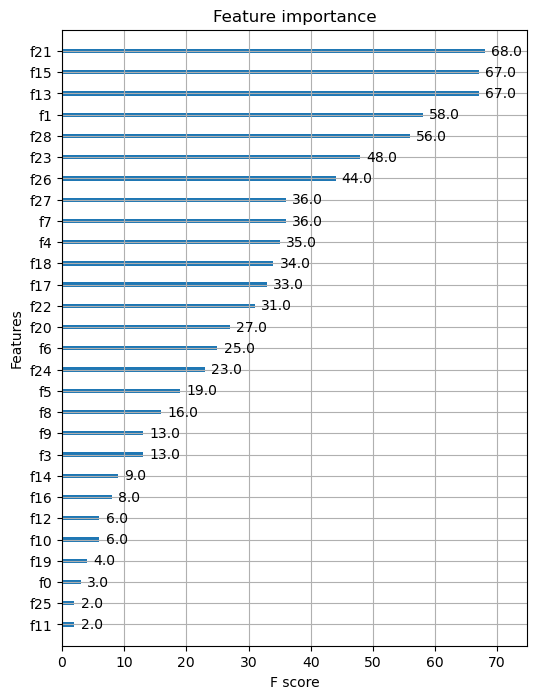

In [28]:
# 1)  xgboost가 제공하는 Plot_importance
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(6, 8))
plot_importance(xgb, ax=ax);

In [29]:
pd.Series(b_cancer.feature_names)

0                 mean radius
1                mean texture
2              mean perimeter
3                   mean area
4             mean smoothness
5            mean compactness
6              mean concavity
7         mean concave points
8               mean symmetry
9      mean fractal dimension
10               radius error
11              texture error
12            perimeter error
13                 area error
14           smoothness error
15          compactness error
16            concavity error
17       concave points error
18             symmetry error
19    fractal dimension error
20               worst radius
21              worst texture
22            worst perimeter
23                 worst area
24           worst smoothness
25          worst compactness
26            worst concavity
27       worst concave points
28             worst symmetry
29    worst fractal dimension
dtype: object

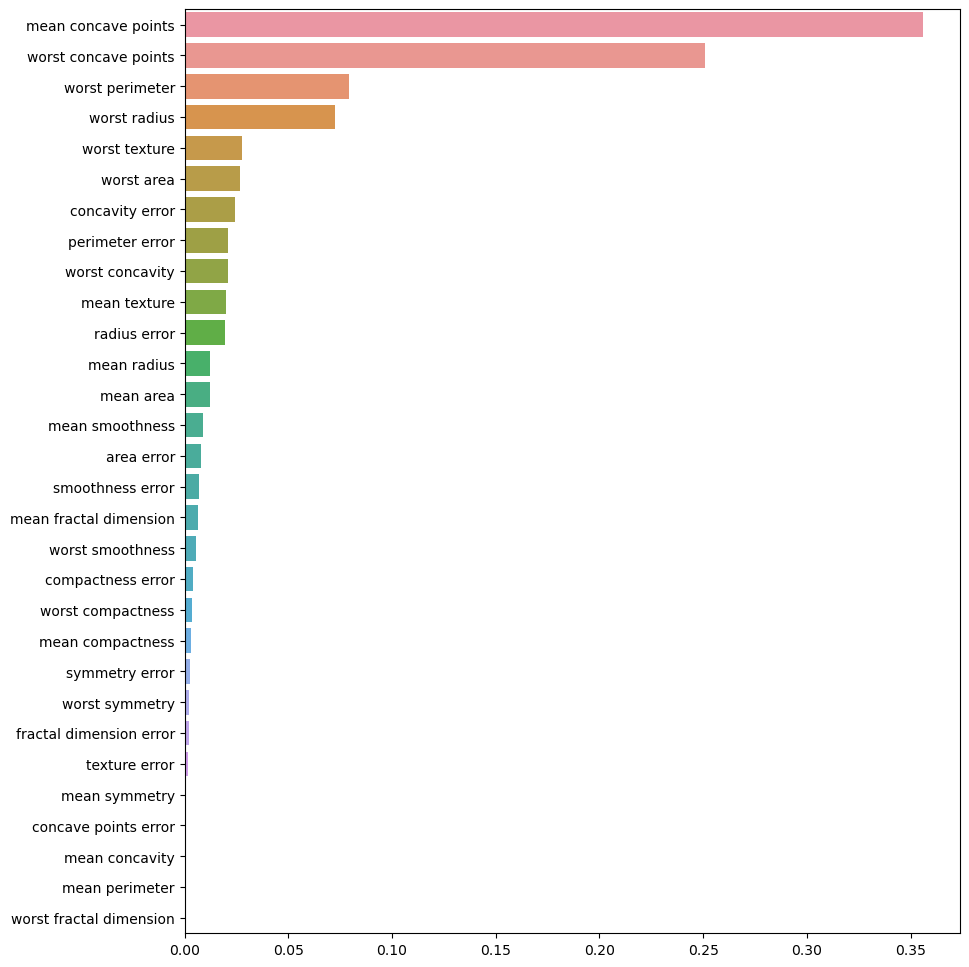

In [26]:

# 2) pandas Series를 활용하는 경우
f_imp = pd.Series(xgb.feature_importances_, b_cancer.feature_names).sort_values(ascending=False)
plt.figure(figsize=(10, 12))
sns.barplot(x=f_imp.values, y=f_imp.index);

In [30]:
xgb.feature_importances_?

Type:        property
String form: <property object at 0x000001F5161C9CC0>
Docstring:  
Feature importances property, return depends on `importance_type`
parameter. When model trained with multi-class/multi-label/multi-target dataset,
the feature importance is "averaged" over all targets. The "average" is defined
based on the importance type. For instance, if the importance type is
"total_gain", then the score is sum of loss change for each split from all
trees.

Returns
-------
feature_importances_ : array of shape ``[n_features]`` except for multi-class
linear model, which returns an array with shape `(n_features, n_classes)`


# LightGBM(LGBM)

In [44]:
import lightgbm

In [ ]:
#!pip install lightgbm

## 위스콘신 유방암 데이터셋

In [ ]:
b_cancer = load_breast_cancer()


#b_cancer를 데이터프레임으로 만드시오(cancer_df)
# 마지막열을 "target"으로 명명하고 결과값을 할당한다.

cancer_df = pd.DataFrame(b_cancer.data, columns=b_cancer.feature_names)
cancer_df["target"] = b_cancer.target

X = b_cancer.data
y = b_cancer.target


# 데이터 분할
# test_size=0.2, random_state=156
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)

In [ ]:
# 조기 중단 옵션을 사용하지 않은 경우

In [48]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators=400, device='gqu')

In [ ]:
# 조기중단 옵션을 사용한 경우

In [49]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators=400, random_state=156)

lgbm.fit(X_train, y_train, early_stopping_rounds=100,
eval_metric='logloss',
eval_set= [(X_test, y_test)],
verbose=True)

[1]	valid_0's binary_logloss: 0.565079
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_logloss: 0.151113
[25]	valid_0's binary_logloss: 0.148395
[26]	vali

LGBMClassifier(n_estimators=400, random_state=156)

In [50]:
get_eval_score(y_train, lgbm.predict(X_train), lgbm.predict_proba(X_train)[:, 1])
get_eval_score(y_test, lgbm.predict(X_test), lgbm.predict_proba(X_test)[:, 1])

----------------------------------------------------------------------------------------------------
오차행렬:
[[175   0]
 [  0 280]]
정확도: 1.0000 정밀도: 1.0000 재현율: 1.0000 F1:1.0000 AUC: 1.0000
----------------------------------------------------------------------------------------------------
오차행렬:
[[33  4]
 [ 1 76]]
정확도: 0.9561 정밀도: 0.9500 재현율: 0.9870 F1:0.9682 AUC: 0.9905


### 시각화

<Figure size 600x400 with 0 Axes>

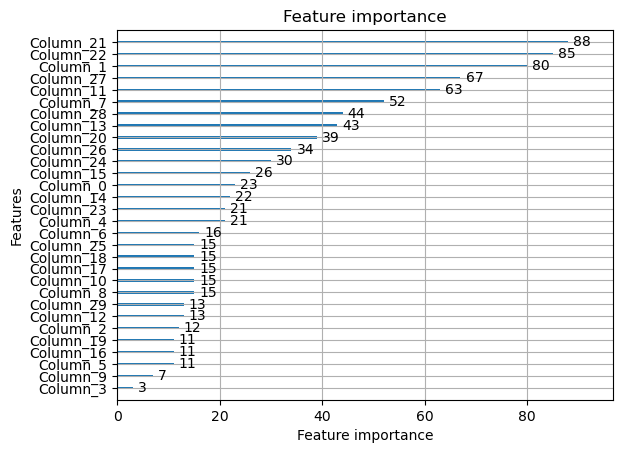

In [51]:
from lightgbm import plot_importance

plt.figure(figsize=(6, 4))
plot_importance(lgbm);

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

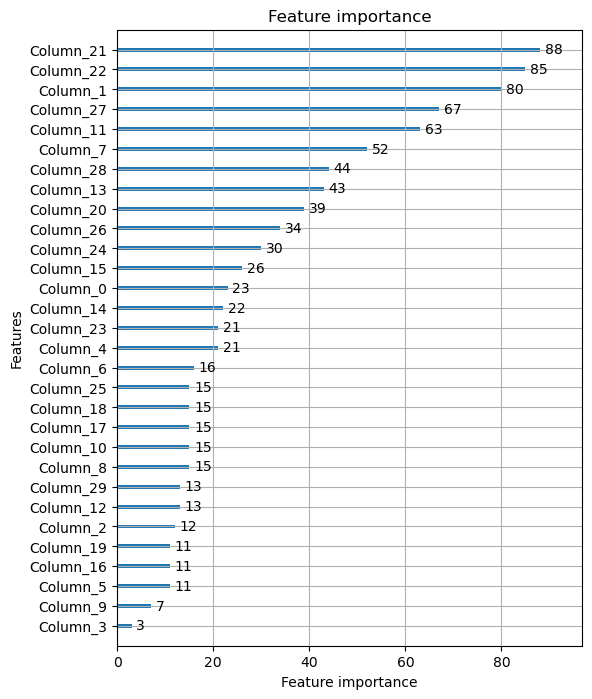

In [52]:
fig, ax = plt.subplots(figsize=(6, 8))
plot_importance(lgbm, ax=ax)

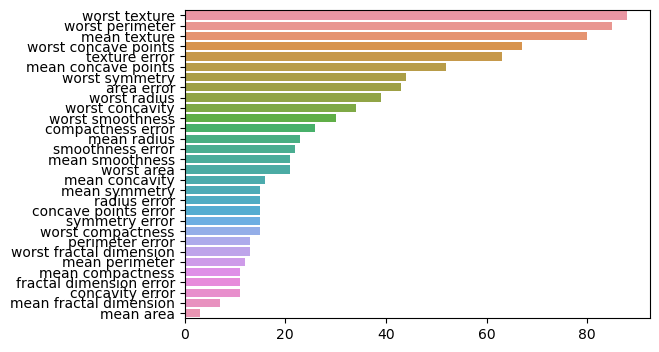

In [60]:
f_imp = pd.Series(lgbm.feature_importances_, index=b_cancer.feature_names).sort_values(ascending=False)
plt.figure(figsize=(6, 4))
sns.barplot(x=f_imp.values, y=f_imp.index);

In [59]:
sns.barplot?

Signature:
sns.barplot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    order=None,
    hue_order=None,
    estimator='mean',
    errorbar=('ci', 95),
    n_boot=1000,
    units=None,
    seed=None,
    orient=None,
    color=None,
    palette=None,
    saturation=0.75,
    width=0.8,
    errcolor='.26',
    errwidth=None,
    capsize=None,
    dodge=True,
    ci='deprecated',
    ax=None,
    **kwargs,
)
Docstring:
Show point estimates and errors as rectangular bars.

A bar plot represents an estimate of central tendency for a numeric
variable with the height of each rectangle and provides some indication of
the uncertainty around that estimate using error bars. Bar plots include 0
in the quantitative axis range, and they are a good choice when 0 is a
meaningful value for the quantitative variable, and you want to make
comparisons against it.

For datasets where 0 is not a meaningful value, a point plot will allow you
to focus on differences between levels of one or mo

In [61]:
LGBMClassifier?

Init signature:
LGBMClassifier(
    boosting_type: str = 'gbdt',
    num_leaves: int = 31,
    max_depth: int = -1,
    learning_rate: float = 0.1,
    n_estimators: int = 100,
    subsample_for_bin: int = 200000,
    objective: Union[str, Callable, NoneType] = None,
    class_weight: Union[Dict, str, NoneType] = None,
    min_split_gain: float = 0.0,
    min_child_weight: float = 0.001,
    min_child_samples: int = 20,
    subsample: float = 1.0,
    subsample_freq: int = 0,
    colsample_bytree: float = 1.0,
    reg_alpha: float = 0.0,
    reg_lambda: float = 0.0,
    random_state: Union[int, numpy.random.mtrand.RandomState, NoneType] = None,
    n_jobs: int = -1,
    silent: Union[bool, str] = 'warn',
    importance_type: str = 'split',
    **kwargs,
)
Docstring:      LightGBM classifier.
Init docstring:
Construct a gradient boosting model.

Parameters
----------
boosting_type : str, optional (default='gbdt')
    'gbdt', traditional Gradient Boosting Decision Tree.
    'dart', Dropo

## CatBoosting

In [63]:
import catboost

In [64]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier()
cb.fit(X_train, y_train)

Learning rate set to 0.00736
0:	learn: 0.6822080	total: 141ms	remaining: 2m 20s
1:	learn: 0.6701892	total: 145ms	remaining: 1m 12s
2:	learn: 0.6582069	total: 150ms	remaining: 49.7s
3:	learn: 0.6477444	total: 155ms	remaining: 38.7s
4:	learn: 0.6358579	total: 160ms	remaining: 31.9s
5:	learn: 0.6268188	total: 164ms	remaining: 27.2s
6:	learn: 0.6157044	total: 169ms	remaining: 24s
7:	learn: 0.6067152	total: 174ms	remaining: 21.6s
8:	learn: 0.5951292	total: 178ms	remaining: 19.6s
9:	learn: 0.5863460	total: 183ms	remaining: 18.2s
10:	learn: 0.5766764	total: 189ms	remaining: 17s
11:	learn: 0.5668565	total: 193ms	remaining: 15.9s
12:	learn: 0.5578108	total: 197ms	remaining: 15s
13:	learn: 0.5492647	total: 203ms	remaining: 14.3s
14:	learn: 0.5411062	total: 206ms	remaining: 13.6s
15:	learn: 0.5330370	total: 210ms	remaining: 12.9s
16:	learn: 0.5257171	total: 215ms	remaining: 12.5s
17:	learn: 0.5179772	total: 220ms	remaining: 12s
18:	learn: 0.5092588	total: 225ms	remaining: 11.6s
19:	learn: 0.50190

In [65]:
get_eval_score(y_test, cb.predict(X_test), cb.predict_proba(X_test)[:, 1])

----------------------------------------------------------------------------------------------------
오차행렬:
[[33  4]
 [ 0 77]]
정확도: 0.9649 정밀도: 0.9506 재현율: 1.0000 F1:0.9747 AUC: 0.9951
